# Gender Determination with Morphometry of Eyes 

## Problem Statement
The anthropometric analysis of the human face is an essential study for performing craniofacial plastic and reconstructive surgeries. Facial anthropometrics are affected by various factors such as age, gender, ethnicity, socioeconomic status, environment, and region.

Plastic surgeons who undertake the repair and reconstruction of facial deformities find the anatomical dimensions of the facial structures useful for their surgeries. These dimensions are a result of the Physical or Facial appearance of an individual. Along with factors like culture, personality, ethnic background, age; eye appearance and symmetry contributes majorly to the facial appearance or aesthetics.

Our objective is to build a model to scan the image of an eye of a patient and find if the gender of the patient is male or female.

## Data source

The dataset used for this project is avaialble on [Kaggle](https://www.kaggle.com/datasets/gauravduttakiit/gender-determination-with-morphometry-of-eyes).

## Solution

To train a binary classification with CNN model.



In [9]:
! kaggle datasets download gauravduttakiit/gender-determination-with-morphometry-of-eyes

100%|██████████████████████████████████████| 25.4M/25.4M [00:05<00:00, 9.85MB/s]
100%|██████████████████████████████████████| 25.4M/25.4M [00:05<00:00, 4.65MB/s]


In [2]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras

from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, BatchNormalization, Flatten, Conv2D
from tensorflow.keras.layers import AveragePooling2D, MaxPooling2D, Dropout, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam

from tensorflow.keras.applications.xception import Xception
# from tensorflow.keras.applications.xception import preprocess_input
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.applications.resnet50 import decode_predictions

from tensorflow.keras.preprocessing.image import load_img

In [4]:
path_dir = 'gender_eye/train/'
male_list = os.listdir(path_dir+'male')
print(len(male_list))
female_list = os.listdir(path_dir+'female')
print(len(female_list))

5058
4162


There are 5058 and 4162 images for male and female gender respectively.

Viewing some images

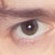

In [8]:
load_img(path_dir+'male/'+male_list[1])


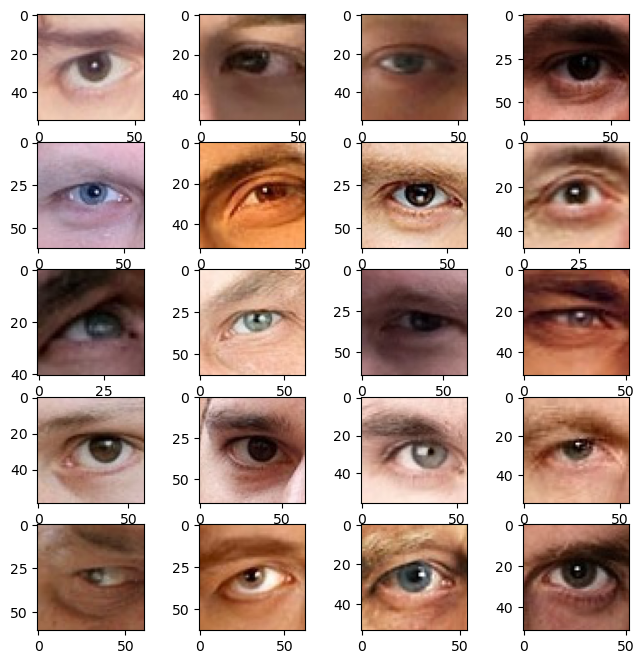

In [14]:
# Viewing male images
fig = plt.figure(figsize=(8, 8))
columns = 4
rows = 5
for i in range(1, columns*rows +1):
    img = load_img(path_dir+'male/'+male_list[i])
    fig.add_subplot(rows, columns, i)
    plt.imshow(img)
plt.show()

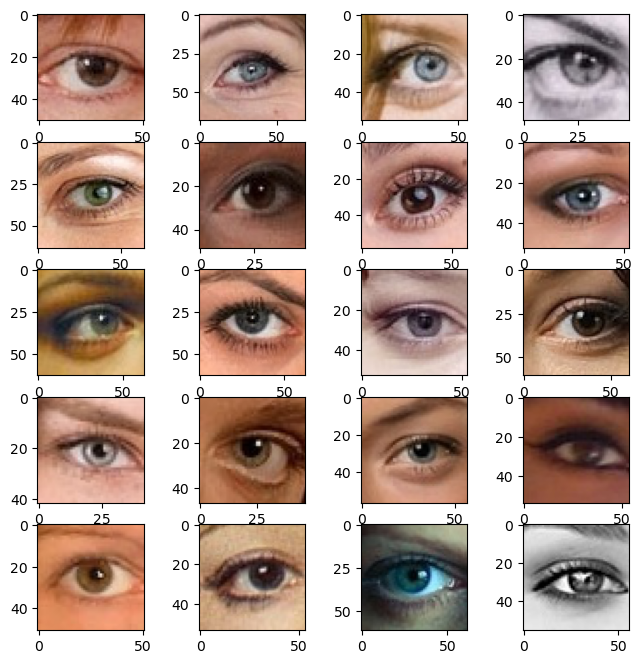

In [15]:
# Viewing female images

fig = plt.figure(figsize=(8, 8))
columns = 4
rows = 5
for i in range(1, columns*rows +1):
    img = load_img(path_dir+'female/'+female_list[i])
    fig.add_subplot(rows, columns, i)
    plt.imshow(img)
plt.show()

## Data Splitting into train and validation sets

In [16]:
# Splitting data into train and val sets with batch size of 30
batch_size = 30

def generators(shape, preprocessing): 
    '''Create the training and validation datasets for 
    a given image shape.
    '''
    imgdatagen = ImageDataGenerator(
        preprocessing_function = preprocessing,
        horizontal_flip = True, 
        validation_split = 0.2,
    )

    height, width = shape

    train_dataset = imgdatagen.flow_from_directory(
        'gender_eye/train',
        target_size = (height, width), 
        classes = ('female','male'),
        batch_size = batch_size,
        subset = 'training', 
    )

    val_dataset = imgdatagen.flow_from_directory(
        'gender_eye/train',
        target_size = (height, width), 
        classes = ('female','male'),
        batch_size = batch_size,
        subset = 'validation'
    )
    return train_dataset, val_dataset

In [17]:
resnet50 = keras.applications.resnet50
train_ds, val_ds = generators((150,150), preprocessing=resnet50.preprocess_input)

Found 7377 images belonging to 2 classes.
Found 1843 images belonging to 2 classes.


## Defining the Transfer learning with ResNet50

In [18]:
conv_model = resnet50.ResNet50(weights='imagenet', include_top=False, input_shape=(150,150,3))
for layer in conv_model.layers:
    layer.trainable = False
x = keras.layers.Flatten()(conv_model.output)
x = keras.layers.Dense(300, activation='relu')(x)
x = keras.layers.Dense(100, activation='relu')(x)
x = keras.layers.Dense(50, activation='relu')(x)
predictions = keras.layers.Dense(2, activation='softmax')(x)
full_model = keras.models.Model(inputs=conv_model.input, outputs=predictions)
full_model.summary()

Metal device set to: Apple M1

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



2023-01-22 14:06:39.897989: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-01-22 14:06:39.900060: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 156, 156, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 75, 75, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 75, 75, 64)   256         ['conv1_conv[0][0]']         

In [19]:
full_model.compile(loss='binary_crossentropy',
                  optimizer=keras.optimizers.Adam(learning_rate=0.01),
                  metrics=['accuracy', 'Precision','Recall', 'AUC',])

In [20]:
history = full_model.fit(
    train_ds, 
    validation_data = val_ds,
    workers=10,
    epochs=10,
    steps_per_epoch=50,
    validation_steps = 5
)

Epoch 1/10


2023-01-22 14:08:31.584484: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-01-22 14:08:32.615086: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


50/50 [==============================] - ETA: 0s - loss: 22.9287 - accuracy: 0.7447 - precision: 0.7447 - recall: 0.7447 - auc: 0.7671

2023-01-22 14:08:44.063901: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


50/50 [==============================] - 14s 236ms/step - loss: 22.9287 - accuracy: 0.7447 - precision: 0.7447 - recall: 0.7447 - auc: 0.7671 - val_loss: 0.4827 - val_accuracy: 0.8467 - val_precision: 0.8467 - val_recall: 0.8467 - val_auc: 0.9150
Epoch 2/10
50/50 [==============================] - 11s 211ms/step - loss: 0.3594 - accuracy: 0.8740 - precision: 0.8740 - recall: 0.8740 - auc: 0.9355 - val_loss: 0.3353 - val_accuracy: 0.8533 - val_precision: 0.8533 - val_recall: 0.8533 - val_auc: 0.9361
Epoch 3/10
50/50 [==============================] - 10s 208ms/step - loss: 0.2610 - accuracy: 0.8920 - precision: 0.8920 - recall: 0.8920 - auc: 0.9580 - val_loss: 0.3514 - val_accuracy: 0.8600 - val_precision: 0.8600 - val_recall: 0.8600 - val_auc: 0.9357
Epoch 4/10
50/50 [==============================] - 11s 214ms/step - loss: 0.2539 - accuracy: 0.8940 - precision: 0.8940 - recall: 0.8940 - auc: 0.9597 - val_loss: 0.2501 - val_accuracy: 0.9067 - val_precision: 0.9067 - val_recall: 0.9067 

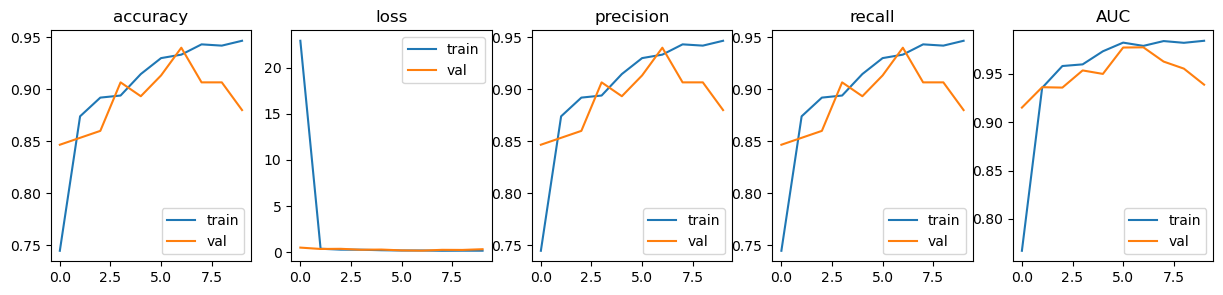

In [25]:
fig, ax = plt.subplots(1, 5, figsize=(15, 3))
ax[0].plot(history.history['accuracy'], label='train')
ax[0].plot(history.history['val_accuracy'], label='val')
ax[0].set_title('accuracy')
ax[0].legend()

ax[1].plot(history.history['loss'], label='train')
ax[1].plot(history.history['val_loss'], label='val')
ax[1].set_title('loss')
ax[1].legend()

ax[2].plot(history.history['precision'], label='train')
ax[2].plot(history.history['val_precision'], label='val')
ax[2].set_title('precision')
ax[2].legend()

ax[3].plot(history.history['recall'], label='train')
ax[3].plot(history.history['val_recall'], label='val')
ax[3].set_title('recall')
ax[3].legend()

ax[4].plot(history.history['auc'], label='train')
ax[4].plot(history.history['val_auc'], label='val')
ax[4].set_title('AUC')
ax[4].legend()

plt.show()

## Model Tuning

In [26]:
def make_model(learning_rate=0.01):
    conv_model = resnet50.ResNet50(weights='imagenet', include_top=False, input_shape=(150,150,3))
    for layer in conv_model.layers:
        layer.trainable = False
    x = keras.layers.Flatten()(conv_model.output)
    x = keras.layers.Dense(300, activation='relu')(x)
    x = keras.layers.Dense(100, activation='relu')(x)
    x = keras.layers.Dense(50, activation='relu')(x)
    predictions = keras.layers.Dense(2, activation='softmax')(x)
    model = keras.models.Model(inputs=conv_model.input, outputs=predictions)
    model.compile(loss='binary_crossentropy',
                  optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
                  metrics=['accuracy', 'Precision','Recall', 'AUC',])
    
    return model

In [29]:
scores = {}

for lr in [0.0001, 0.001, 0.01, 0.1]:
    print(lr)

    model = make_model(learning_rate=lr)

    history = model.fit(
    train_ds, 
    validation_data = val_ds,
    workers=10,
    epochs=10,
    steps_per_epoch=50,
    validation_steps = 5)

    scores[lr] = history.history

    print()
    print()

0.0001
Epoch 1/10


2023-01-22 14:35:09.238661: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


50/50 [==============================] - ETA: 0s - loss: 0.4078 - accuracy: 0.8297 - precision: 0.8297 - recall: 0.8297 - auc: 0.9068

2023-01-22 14:35:22.174429: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


50/50 [==============================] - 16s 274ms/step - loss: 0.4078 - accuracy: 0.8297 - precision: 0.8297 - recall: 0.8297 - auc: 0.9068 - val_loss: 0.3214 - val_accuracy: 0.8667 - val_precision: 0.8667 - val_recall: 0.8667 - val_auc: 0.9375
Epoch 2/10
50/50 [==============================] - 11s 216ms/step - loss: 0.2453 - accuracy: 0.8960 - precision: 0.8960 - recall: 0.8960 - auc: 0.9591 - val_loss: 0.1991 - val_accuracy: 0.9067 - val_precision: 0.9067 - val_recall: 0.9067 - val_auc: 0.9744
Epoch 3/10
50/50 [==============================] - 11s 219ms/step - loss: 0.1819 - accuracy: 0.9280 - precision: 0.9280 - recall: 0.9280 - auc: 0.9769 - val_loss: 0.2531 - val_accuracy: 0.9000 - val_precision: 0.9000 - val_recall: 0.9000 - val_auc: 0.9510
Epoch 4/10
50/50 [==============================] - 11s 219ms/step - loss: 0.1658 - accuracy: 0.9287 - precision: 0.9287 - recall: 0.9287 - auc: 0.9796 - val_loss: 0.2019 - val_accuracy: 0.9000 - val_precision: 0.9000 - val_recall: 0.9000 -

2023-01-22 14:37:06.257915: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


50/50 [==============================] - ETA: 0s - loss: 1.3792 - accuracy: 0.7967 - precision: 0.7967 - recall: 0.7967 - auc: 0.8424

2023-01-22 14:37:18.705941: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


50/50 [==============================] - 17s 261ms/step - loss: 1.3792 - accuracy: 0.7967 - precision: 0.7967 - recall: 0.7967 - auc: 0.8424 - val_loss: 1.2343 - val_accuracy: 0.8600 - val_precision: 0.8600 - val_recall: 0.8600 - val_auc: 0.8630
Epoch 2/10
50/50 [==============================] - 11s 223ms/step - loss: 0.5438 - accuracy: 0.8838 - precision: 0.8838 - recall: 0.8838 - auc: 0.9220 - val_loss: 0.3269 - val_accuracy: 0.9200 - val_precision: 0.9200 - val_recall: 0.9200 - val_auc: 0.9387
Epoch 3/10
50/50 [==============================] - 10s 208ms/step - loss: 0.3803 - accuracy: 0.9047 - precision: 0.9047 - recall: 0.9047 - auc: 0.9451 - val_loss: 0.2139 - val_accuracy: 0.9267 - val_precision: 0.9267 - val_recall: 0.9267 - val_auc: 0.9668
Epoch 4/10
50/50 [==============================] - 10s 207ms/step - loss: 0.2600 - accuracy: 0.9200 - precision: 0.9200 - recall: 0.9200 - auc: 0.9610 - val_loss: 0.3781 - val_accuracy: 0.9200 - val_precision: 0.9200 - val_recall: 0.9200 -

2023-01-22 14:38:58.420199: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


50/50 [==============================] - ETA: 0s - loss: 13.9760 - accuracy: 0.7880 - precision: 0.7880 - recall: 0.7880 - auc: 0.8089

2023-01-22 14:39:10.655869: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


50/50 [==============================] - 16s 257ms/step - loss: 13.9760 - accuracy: 0.7880 - precision: 0.7880 - recall: 0.7880 - auc: 0.8089 - val_loss: 0.7877 - val_accuracy: 0.8933 - val_precision: 0.8933 - val_recall: 0.8933 - val_auc: 0.9268
Epoch 2/10
50/50 [==============================] - 10s 207ms/step - loss: 0.5283 - accuracy: 0.8913 - precision: 0.8913 - recall: 0.8913 - auc: 0.9311 - val_loss: 0.4194 - val_accuracy: 0.8867 - val_precision: 0.8867 - val_recall: 0.8867 - val_auc: 0.9362
Epoch 3/10
50/50 [==============================] - 11s 229ms/step - loss: 0.4069 - accuracy: 0.8864 - precision: 0.8864 - recall: 0.8864 - auc: 0.9356 - val_loss: 0.5090 - val_accuracy: 0.8467 - val_precision: 0.8467 - val_recall: 0.8467 - val_auc: 0.9056
Epoch 4/10
50/50 [==============================] - 11s 226ms/step - loss: 0.2854 - accuracy: 0.9100 - precision: 0.9100 - recall: 0.9100 - auc: 0.9549 - val_loss: 0.2780 - val_accuracy: 0.8867 - val_precision: 0.8867 - val_recall: 0.8867 

2023-01-22 14:41:01.374056: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


50/50 [==============================] - ETA: 0s - loss: 1562.2833 - accuracy: 0.5280 - precision: 0.5280 - recall: 0.5280 - auc: 0.5350

2023-01-22 14:41:14.878179: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


50/50 [==============================] - 17s 294ms/step - loss: 1562.2833 - accuracy: 0.5280 - precision: 0.5280 - recall: 0.5280 - auc: 0.5350 - val_loss: 0.6890 - val_accuracy: 0.6000 - val_precision: 0.6000 - val_recall: 0.6000 - val_auc: 0.6000
Epoch 2/10
50/50 [==============================] - 11s 226ms/step - loss: 0.7347 - accuracy: 0.5540 - precision: 0.5540 - recall: 0.5540 - auc: 0.5391 - val_loss: 0.7008 - val_accuracy: 0.5000 - val_precision: 0.5000 - val_recall: 0.5000 - val_auc: 0.5000
Epoch 3/10
50/50 [==============================] - 11s 224ms/step - loss: 0.6942 - accuracy: 0.5293 - precision: 0.5293 - recall: 0.5293 - auc: 0.5103 - val_loss: 0.6959 - val_accuracy: 0.5067 - val_precision: 0.5067 - val_recall: 0.5067 - val_auc: 0.5067
Epoch 4/10
50/50 [==============================] - 11s 224ms/step - loss: 0.6897 - accuracy: 0.5473 - precision: 0.5473 - recall: 0.5473 - auc: 0.5416 - val_loss: 0.6780 - val_accuracy: 0.6067 - val_precision: 0.6067 - val_recall: 0.606

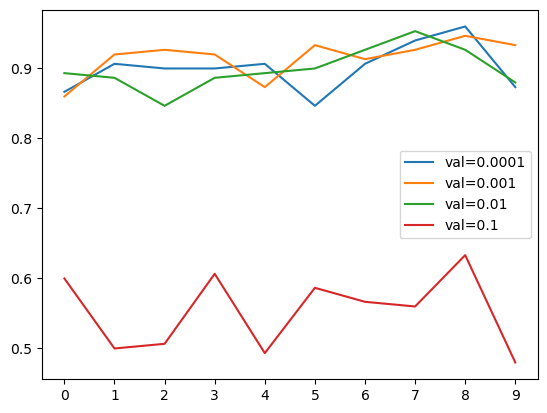

In [30]:
for lr, hist in scores.items():
    #plt.plot(hist['accuracy'], label=('train=%s' % lr))
    plt.plot(hist['val_accuracy'], label=('val=%s' % lr))

plt.xticks(np.arange(10))
plt.legend()

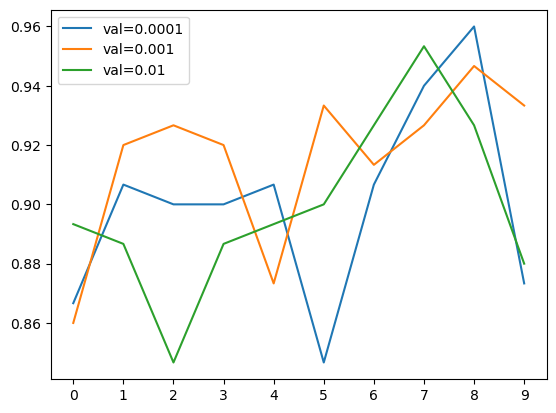

In [31]:
del scores[0.1]

for lr, hist in scores.items():
    #plt.plot(hist['accuracy'], label=('train=%s' % lr))
    plt.plot(hist['val_accuracy'], label=('val=%s' % lr))

plt.xticks(np.arange(10))
plt.legend()

In [32]:
def make_model(learning_rate=0.001, size_inner=100):
    conv_model = resnet50.ResNet50(weights='imagenet', include_top=False, input_shape=(150,150,3))
    for layer in conv_model.layers:
        layer.trainable = False
    x = keras.layers.Flatten()(conv_model.output)
    x = keras.layers.Dense(300, activation='relu')(x)
    x = keras.layers.Dense(size_inner, activation='relu')(x)
    x = keras.layers.Dense(50, activation='relu')(x)
    predictions = keras.layers.Dense(2, activation='softmax')(x)
    model = keras.models.Model(inputs=conv_model.input, outputs=predictions)
    model.compile(loss='binary_crossentropy',
                  optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
                  metrics=['accuracy', 'Precision','Recall', 'AUC',])
    
    return model

In [33]:
lr = 0.001

scores = {}

for size in [100, 200, 250]:
    print(size)

    model = make_model(learning_rate=lr, size_inner=size)

    history = model.fit(
    train_ds, 
    validation_data = val_ds,
    workers=10,
    epochs=10,
    steps_per_epoch=50,
    validation_steps = 5)

    scores[size] = history.history

    print()
    print()

100
Epoch 1/10


2023-01-22 15:11:30.834576: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


50/50 [==============================] - ETA: 0s - loss: 2.0073 - accuracy: 0.7967 - precision: 0.7967 - recall: 0.7967 - auc: 0.8304

2023-01-22 15:11:43.639926: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


50/50 [==============================] - 20s 265ms/step - loss: 2.0073 - accuracy: 0.7967 - precision: 0.7967 - recall: 0.7967 - auc: 0.8304 - val_loss: 0.5365 - val_accuracy: 0.9133 - val_precision: 0.9133 - val_recall: 0.9133 - val_auc: 0.9397
Epoch 2/10
50/50 [==============================] - 11s 217ms/step - loss: 0.4193 - accuracy: 0.8893 - precision: 0.8893 - recall: 0.8893 - auc: 0.9268 - val_loss: 1.0605 - val_accuracy: 0.7200 - val_precision: 0.7200 - val_recall: 0.7200 - val_auc: 0.7932
Epoch 3/10
50/50 [==============================] - 11s 223ms/step - loss: 0.3923 - accuracy: 0.8967 - precision: 0.8967 - recall: 0.8967 - auc: 0.9358 - val_loss: 0.3049 - val_accuracy: 0.9133 - val_precision: 0.9133 - val_recall: 0.9133 - val_auc: 0.9435
Epoch 4/10
50/50 [==============================] - 12s 241ms/step - loss: 0.2571 - accuracy: 0.9118 - precision: 0.9118 - recall: 0.9118 - auc: 0.9603 - val_loss: 0.1840 - val_accuracy: 0.9267 - val_precision: 0.9267 - val_recall: 0.9267 -

2023-01-22 15:13:28.997132: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


50/50 [==============================] - ETA: 0s - loss: 2.0702 - accuracy: 0.7840 - precision: 0.7840 - recall: 0.7840 - auc: 0.8238

2023-01-22 15:13:42.408737: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


50/50 [==============================] - 17s 276ms/step - loss: 2.0702 - accuracy: 0.7840 - precision: 0.7840 - recall: 0.7840 - auc: 0.8238 - val_loss: 0.3632 - val_accuracy: 0.9067 - val_precision: 0.9067 - val_recall: 0.9067 - val_auc: 0.9406
Epoch 2/10
50/50 [==============================] - 12s 244ms/step - loss: 0.4399 - accuracy: 0.8931 - precision: 0.8931 - recall: 0.8931 - auc: 0.9325 - val_loss: 0.3596 - val_accuracy: 0.8600 - val_precision: 0.8600 - val_recall: 0.8600 - val_auc: 0.9336
Epoch 3/10
50/50 [==============================] - 11s 216ms/step - loss: 0.3818 - accuracy: 0.8947 - precision: 0.8947 - recall: 0.8947 - auc: 0.9400 - val_loss: 0.4289 - val_accuracy: 0.9067 - val_precision: 0.9067 - val_recall: 0.9067 - val_auc: 0.9554
Epoch 4/10
50/50 [==============================] - 11s 217ms/step - loss: 0.3060 - accuracy: 0.9087 - precision: 0.9087 - recall: 0.9087 - auc: 0.9548 - val_loss: 0.1767 - val_accuracy: 0.9333 - val_precision: 0.9333 - val_recall: 0.9333 -

2023-01-22 15:15:27.033143: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


50/50 [==============================] - ETA: 0s - loss: 1.4338 - accuracy: 0.7893 - precision: 0.7893 - recall: 0.7893 - auc: 0.8337

2023-01-22 15:15:40.866999: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


50/50 [==============================] - 19s 302ms/step - loss: 1.4338 - accuracy: 0.7893 - precision: 0.7893 - recall: 0.7893 - auc: 0.8337 - val_loss: 0.4483 - val_accuracy: 0.8733 - val_precision: 0.8733 - val_recall: 0.8733 - val_auc: 0.9282
Epoch 2/10
50/50 [==============================] - 13s 261ms/step - loss: 0.3302 - accuracy: 0.8978 - precision: 0.8978 - recall: 0.8978 - auc: 0.9542 - val_loss: 0.3535 - val_accuracy: 0.8800 - val_precision: 0.8800 - val_recall: 0.8800 - val_auc: 0.9281
Epoch 3/10
50/50 [==============================] - 14s 287ms/step - loss: 0.2695 - accuracy: 0.9180 - precision: 0.9180 - recall: 0.9180 - auc: 0.9643 - val_loss: 0.3654 - val_accuracy: 0.9067 - val_precision: 0.9067 - val_recall: 0.9067 - val_auc: 0.9311
Epoch 4/10
50/50 [==============================] - 16s 313ms/step - loss: 0.2088 - accuracy: 0.9293 - precision: 0.9293 - recall: 0.9293 - auc: 0.9746 - val_loss: 0.1555 - val_accuracy: 0.9400 - val_precision: 0.9400 - val_recall: 0.9400 -

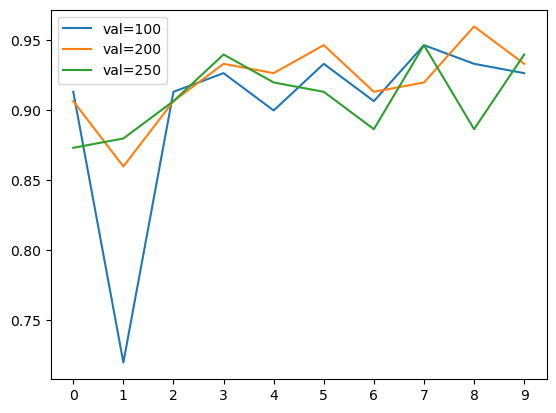

In [35]:
for size, hist in scores.items():
    plt.plot(hist['val_accuracy'], label=('val=%s' % size))

plt.xticks(np.arange(10))
# plt.yticks([0.78, 0.80, 0.82, 0.825, 0.83])
plt.legend()

In [36]:
def make_model(learning_rate=0.001, size_inner=200, droprate=0.5):
    conv_model = resnet50.ResNet50(weights='imagenet', include_top=False, input_shape=(150,150,3))
    for layer in conv_model.layers:
        layer.trainable = False
    x = keras.layers.Flatten()(conv_model.output)
    x = keras.layers.Dense(300, activation='relu')(x)
    x = keras.layers.Dense(size_inner, activation='relu')(x)
    x = keras.layers.Dense(50, activation='relu')(x)
    drop = keras.layers.Dropout(droprate)(x)
    predictions = keras.layers.Dense(2, activation='softmax')(drop)
    model = keras.models.Model(inputs=conv_model.input, outputs=predictions)
    model.compile(loss='binary_crossentropy',
                  optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
                  metrics=['accuracy', 'Precision','Recall', 'AUC',])
    
    return model

In [37]:
lr = 0.001
size = 200

scores = {}

for droprate in [0.0, 0.2, 0.5, 0.8]:
    print(droprate)

    model = make_model(learning_rate=lr, size_inner=size, droprate=droprate)

    history = model.fit(
    train_ds, 
    validation_data = val_ds,
    workers=10,
    epochs=10,
    steps_per_epoch=50,
    validation_steps = 5)

    scores[droprate] = history.history

    print()
    print()

0.0
Epoch 1/10


2023-01-22 15:37:43.029662: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


50/50 [==============================] - ETA: 0s - loss: 1.4559 - accuracy: 0.7987 - precision: 0.7987 - recall: 0.7987 - auc: 0.8408

2023-01-22 15:37:56.235678: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


50/50 [==============================] - 22s 291ms/step - loss: 1.4559 - accuracy: 0.7987 - precision: 0.7987 - recall: 0.7987 - auc: 0.8408 - val_loss: 0.8957 - val_accuracy: 0.8067 - val_precision: 0.8067 - val_recall: 0.8067 - val_auc: 0.8509
Epoch 2/10
50/50 [==============================] - 13s 256ms/step - loss: 0.6882 - accuracy: 0.8537 - precision: 0.8537 - recall: 0.8537 - auc: 0.8908 - val_loss: 0.7355 - val_accuracy: 0.8200 - val_precision: 0.8200 - val_recall: 0.8200 - val_auc: 0.8633
Epoch 3/10
50/50 [==============================] - 11s 223ms/step - loss: 0.2822 - accuracy: 0.9078 - precision: 0.9078 - recall: 0.9078 - auc: 0.9537 - val_loss: 0.1532 - val_accuracy: 0.9400 - val_precision: 0.9400 - val_recall: 0.9400 - val_auc: 0.9855
Epoch 4/10
50/50 [==============================] - 11s 226ms/step - loss: 0.2010 - accuracy: 0.9273 - precision: 0.9273 - recall: 0.9273 - auc: 0.9720 - val_loss: 0.6938 - val_accuracy: 0.8200 - val_precision: 0.8200 - val_recall: 0.8200 -

2023-01-22 15:39:42.991599: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


50/50 [==============================] - ETA: 0s - loss: 1.4097 - accuracy: 0.7947 - precision: 0.7947 - recall: 0.7947 - auc: 0.8409

2023-01-22 15:39:57.115443: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


50/50 [==============================] - 18s 293ms/step - loss: 1.4097 - accuracy: 0.7947 - precision: 0.7947 - recall: 0.7947 - auc: 0.8409 - val_loss: 0.2265 - val_accuracy: 0.9467 - val_precision: 0.9467 - val_recall: 0.9467 - val_auc: 0.9723
Epoch 2/10
50/50 [==============================] - 12s 239ms/step - loss: 0.3378 - accuracy: 0.8567 - precision: 0.8567 - recall: 0.8567 - auc: 0.9420 - val_loss: 0.3317 - val_accuracy: 0.8400 - val_precision: 0.8400 - val_recall: 0.8400 - val_auc: 0.9432
Epoch 3/10
50/50 [==============================] - 11s 215ms/step - loss: 0.3405 - accuracy: 0.8713 - precision: 0.8713 - recall: 0.8713 - auc: 0.9443 - val_loss: 0.3255 - val_accuracy: 0.9133 - val_precision: 0.9133 - val_recall: 0.9133 - val_auc: 0.9580
Epoch 4/10
50/50 [==============================] - 11s 210ms/step - loss: 0.3213 - accuracy: 0.8553 - precision: 0.8553 - recall: 0.8553 - auc: 0.9464 - val_loss: 0.2315 - val_accuracy: 0.8867 - val_precision: 0.8867 - val_recall: 0.8867 -

2023-01-22 15:41:42.491230: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


50/50 [==============================] - ETA: 0s - loss: 1.6976 - accuracy: 0.7120 - precision: 0.7120 - recall: 0.7120 - auc: 0.7423

2023-01-22 15:41:55.664391: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


50/50 [==============================] - 17s 286ms/step - loss: 1.6976 - accuracy: 0.7120 - precision: 0.7120 - recall: 0.7120 - auc: 0.7423 - val_loss: 0.4247 - val_accuracy: 0.8667 - val_precision: 0.8667 - val_recall: 0.8667 - val_auc: 0.9168
Epoch 2/10
50/50 [==============================] - 13s 251ms/step - loss: 0.4458 - accuracy: 0.8187 - precision: 0.8187 - recall: 0.8187 - auc: 0.8901 - val_loss: 0.3642 - val_accuracy: 0.8400 - val_precision: 0.8400 - val_recall: 0.8400 - val_auc: 0.9212
Epoch 3/10
50/50 [==============================] - 11s 215ms/step - loss: 0.3900 - accuracy: 0.8460 - precision: 0.8460 - recall: 0.8460 - auc: 0.9144 - val_loss: 0.2701 - val_accuracy: 0.9067 - val_precision: 0.9067 - val_recall: 0.9067 - val_auc: 0.9543
Epoch 4/10
50/50 [==============================] - 11s 217ms/step - loss: 0.3684 - accuracy: 0.8633 - precision: 0.8633 - recall: 0.8633 - auc: 0.9219 - val_loss: 0.2216 - val_accuracy: 0.9400 - val_precision: 0.9400 - val_recall: 0.9400 -

2023-01-22 15:44:03.575786: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


50/50 [==============================] - ETA: 0s - loss: 1.1773 - accuracy: 0.5633 - precision: 0.5633 - recall: 0.5633 - auc: 0.5753

2023-01-22 15:44:25.840430: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


50/50 [==============================] - 31s 491ms/step - loss: 1.1773 - accuracy: 0.5633 - precision: 0.5633 - recall: 0.5633 - auc: 0.5753 - val_loss: 0.6889 - val_accuracy: 0.5533 - val_precision: 0.5533 - val_recall: 0.5533 - val_auc: 0.5593
Epoch 2/10
50/50 [==============================] - 21s 427ms/step - loss: 0.6916 - accuracy: 0.5424 - precision: 0.5424 - recall: 0.5424 - auc: 0.5473 - val_loss: 0.6916 - val_accuracy: 0.5467 - val_precision: 0.5467 - val_recall: 0.5467 - val_auc: 0.5467
Epoch 3/10
50/50 [==============================] - 15s 304ms/step - loss: 0.6956 - accuracy: 0.5753 - precision: 0.5753 - recall: 0.5753 - auc: 0.5742 - val_loss: 0.6915 - val_accuracy: 0.5333 - val_precision: 0.5333 - val_recall: 0.5333 - val_auc: 0.5333
Epoch 4/10
50/50 [==============================] - 15s 294ms/step - loss: 0.6893 - accuracy: 0.5611 - precision: 0.5611 - recall: 0.5611 - auc: 0.5684 - val_loss: 0.6918 - val_accuracy: 0.5267 - val_precision: 0.5267 - val_recall: 0.5267 -

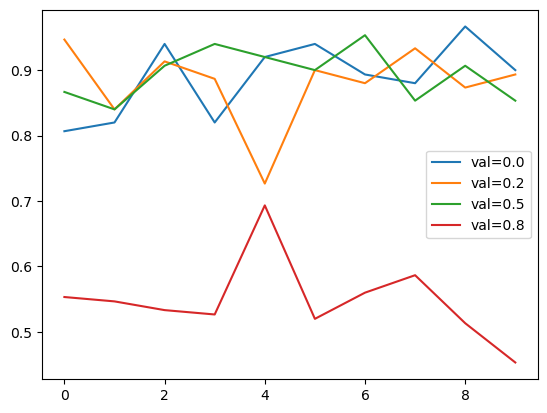

In [39]:
for droprate, hist in scores.items():
    plt.plot(hist['val_accuracy'], label=('val=%s' % droprate))

# plt.ylim(0.78, 0.86)
plt.legend()

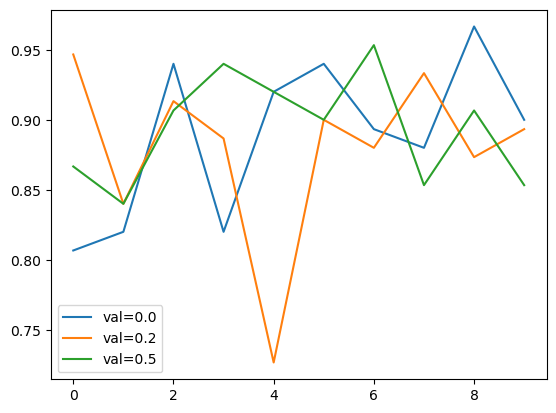

In [40]:
del scores[0.8]

for droprate, hist in scores.items():
    plt.plot(hist['val_accuracy'], label=('val=%s' % droprate))

plt.legend()

### Train large data

In [41]:
lr = 0.001
size = 200
droprate = 0.0
input_size = 224

In [49]:
# Splitting data into train and val sets with batch size of 30
batch_size = 30

def generators(shape, preprocessing): 
    '''Create the training and validation datasets for 
    a given image shape.
    '''
    imgdatagen = ImageDataGenerator(
        preprocessing_function = preprocessing,
        horizontal_flip = True,
        shear_range=10,
        zoom_range=0.1,
        rotation_range=20,
        validation_split = 0.2,
    )

    height, width = shape

    train_dataset = imgdatagen.flow_from_directory(
        'gender_eye/train',
        target_size = (height, width), 
        classes = ('female','male'),
        batch_size = batch_size,
        subset = 'training', 
    )

    val_dataset = imgdatagen.flow_from_directory(
        'gender_eye/train',
        target_size = (height, width), 
        classes = ('female','male'),
        batch_size = batch_size,
        subset = 'validation',
        shuffle=False
    )
    return train_dataset, val_dataset

In [50]:
resnet50 = keras.applications.resnet50
train_ds, val_ds = generators((input_size, input_size), preprocessing=resnet50.preprocess_input)

Found 7377 images belonging to 2 classes.
Found 1843 images belonging to 2 classes.


In [51]:
conv_model = resnet50.ResNet50(weights='imagenet', include_top=False, input_shape=(input_size,input_size,3))
for layer in conv_model.layers:
    layer.trainable = False
x = keras.layers.Flatten()(conv_model.output)
x = keras.layers.Dense(300, activation='relu')(x)
x = keras.layers.Dense(size, activation='relu')(x)
x = keras.layers.Dense(50, activation='relu')(x)
drop = keras.layers.Dropout(droprate)(x)
predictions = keras.layers.Dense(2, activation='softmax')(drop)
full_model = keras.models.Model(inputs=conv_model.input, outputs=predictions)
full_model.summary()

Model: "model_17"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_18 (InputLayer)          [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_18[0][0]']               
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

In [52]:
full_model.compile(loss='binary_crossentropy',
                  optimizer=keras.optimizers.Adam(learning_rate=lr),
                  metrics=['accuracy', 'Precision','Recall', 'AUC',])

In [53]:
history = full_model.fit(
    train_ds, 
    validation_data = val_ds,
    workers=10,
    epochs=20,
    steps_per_epoch=50,
    validation_steps = 5
)

Epoch 1/20


2023-01-22 17:28:17.547697: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


50/50 [==============================] - ETA: 0s - loss: 3.7308 - accuracy: 0.7493 - precision: 0.7493 - recall: 0.7493 - auc: 0.7856

2023-01-22 17:28:41.266060: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


50/50 [==============================] - 30s 521ms/step - loss: 3.7308 - accuracy: 0.7493 - precision: 0.7493 - recall: 0.7493 - auc: 0.7856 - val_loss: 1.9790 - val_accuracy: 0.6333 - val_precision: 0.6333 - val_recall: 0.6333 - val_auc: 0.6525
Epoch 2/20
50/50 [==============================] - 22s 426ms/step - loss: 0.6503 - accuracy: 0.8527 - precision: 0.8527 - recall: 0.8527 - auc: 0.8965 - val_loss: 0.4001 - val_accuracy: 0.9133 - val_precision: 0.9133 - val_recall: 0.9133 - val_auc: 0.9503
Epoch 3/20
50/50 [==============================] - 22s 428ms/step - loss: 0.4507 - accuracy: 0.8840 - precision: 0.8840 - recall: 0.8840 - auc: 0.9287 - val_loss: 0.3710 - val_accuracy: 0.8733 - val_precision: 0.8733 - val_recall: 0.8733 - val_auc: 0.9246
Epoch 4/20
50/50 [==============================] - 22s 425ms/step - loss: 0.4280 - accuracy: 0.8693 - precision: 0.8693 - recall: 0.8693 - auc: 0.9248 - val_loss: 0.3107 - val_accuracy: 0.9267 - val_precision: 0.9267 - val_recall: 0.9267 -

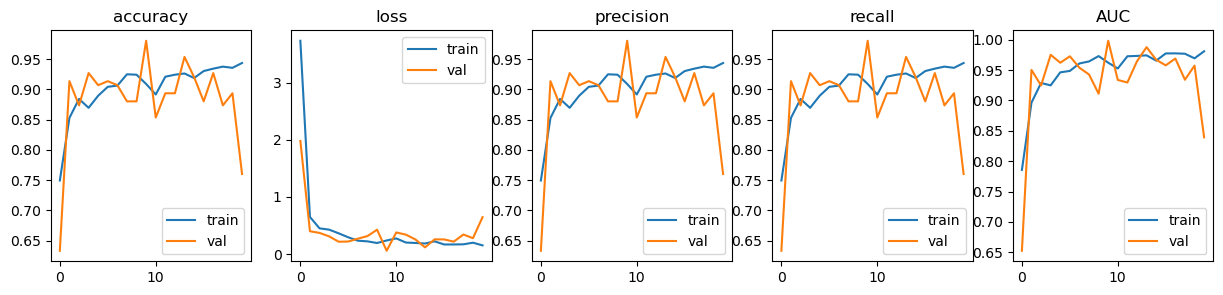

In [54]:
fig, ax = plt.subplots(1, 5, figsize=(15, 3))
ax[0].plot(history.history['accuracy'], label='train')
ax[0].plot(history.history['val_accuracy'], label='val')
ax[0].set_title('accuracy')
ax[0].legend()

ax[1].plot(history.history['loss'], label='train')
ax[1].plot(history.history['val_loss'], label='val')
ax[1].set_title('loss')
ax[1].legend()

ax[2].plot(history.history['precision'], label='train')
ax[2].plot(history.history['val_precision'], label='val')
ax[2].set_title('precision')
ax[2].legend()

ax[3].plot(history.history['recall'], label='train')
ax[3].plot(history.history['val_recall'], label='val')
ax[3].set_title('recall')
ax[3].legend()

ax[4].plot(history.history['auc'], label='train')
ax[4].plot(history.history['val_auc'], label='val')
ax[4].set_title('AUC')
ax[4].legend()

plt.show()

In [55]:
def make_model(input_size=150, learning_rate=0.001, size_inner=200, droprate=0.5):
    conv_model = resnet50.ResNet50(weights='imagenet', include_top=False, input_shape=(input_size, input_size, 3))
    for layer in conv_model.layers:
        layer.trainable = False
    x = keras.layers.Flatten()(conv_model.output)
    x = keras.layers.Dense(300, activation='relu')(x)
    x = keras.layers.Dense(size_inner, activation='relu')(x)
    x = keras.layers.Dense(50, activation='relu')(x)
    drop = keras.layers.Dropout(droprate)(x)
    predictions = keras.layers.Dense(2, activation='softmax')(drop)
    model = keras.models.Model(inputs=conv_model.input, outputs=predictions)
    model.compile(loss='binary_crossentropy',
                  optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
                  metrics=['accuracy', 'Precision','Recall', 'AUC',])
    
    return model

In [59]:
checkpoint = keras.callbacks.ModelCheckpoint(
    'resnet_v1_{epoch:02d}_{val_accuracy:.3f}.h5',
    save_best_only=True,
    monitor='val_accuracy',
    mode='max'
)

In [60]:
model = make_model(input_size=input_size,
                   learning_rate=lr,
                   size_inner=size,
                   droprate=droprate)

In [61]:
history = model.fit(
    train_ds, 
    validation_data = val_ds,
    workers=10,
    epochs=30,
    steps_per_epoch=50,
    validation_steps=5,
    callbacks=[checkpoint])

Epoch 1/30


2023-01-22 17:41:01.278795: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


50/50 [==============================] - ETA: 0s - loss: 3.1545 - accuracy: 0.7127 - precision: 0.7127 - recall: 0.7127 - auc: 0.7532

2023-01-22 17:41:30.164790: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


50/50 [==============================] - 36s 621ms/step - loss: 3.1545 - accuracy: 0.7127 - precision: 0.7127 - recall: 0.7127 - auc: 0.7532 - val_loss: 0.2652 - val_accuracy: 0.9267 - val_precision: 0.9267 - val_recall: 0.9267 - val_auc: 0.9568
Epoch 2/30
50/50 [==============================] - 24s 461ms/step - loss: 0.5353 - accuracy: 0.8627 - precision: 0.8627 - recall: 0.8627 - auc: 0.9141 - val_loss: 0.0892 - val_accuracy: 0.9733 - val_precision: 0.9733 - val_recall: 0.9733 - val_auc: 0.9920
Epoch 3/30
50/50 [==============================] - 24s 469ms/step - loss: 0.4723 - accuracy: 0.8644 - precision: 0.8644 - recall: 0.8644 - auc: 0.9186 - val_loss: 0.1949 - val_accuracy: 0.9467 - val_precision: 0.9467 - val_recall: 0.9467 - val_auc: 0.9733
Epoch 4/30
50/50 [==============================] - 22s 428ms/step - loss: 0.3163 - accuracy: 0.9020 - precision: 0.9020 - recall: 0.9020 - auc: 0.9531 - val_loss: 0.2341 - val_accuracy: 0.9400 - val_precision: 0.9400 - val_recall: 0.9400 -

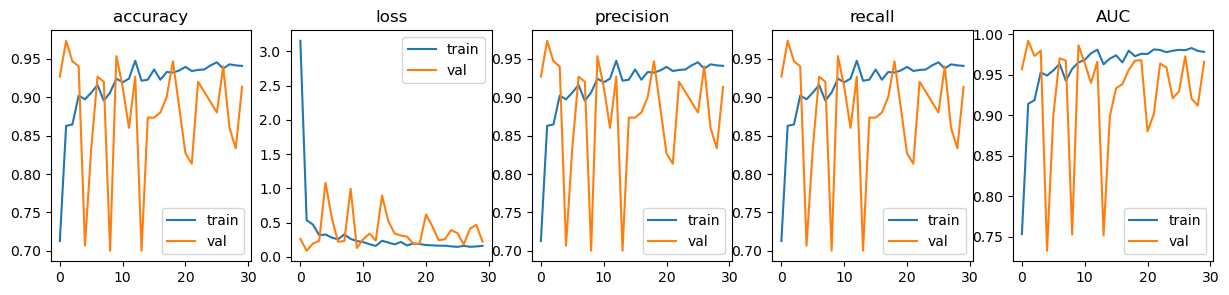

In [62]:
fig, ax = plt.subplots(1, 5, figsize=(15, 3))
ax[0].plot(history.history['accuracy'], label='train')
ax[0].plot(history.history['val_accuracy'], label='val')
ax[0].set_title('accuracy')
ax[0].legend()

ax[1].plot(history.history['loss'], label='train')
ax[1].plot(history.history['val_loss'], label='val')
ax[1].set_title('loss')
ax[1].legend()

ax[2].plot(history.history['precision'], label='train')
ax[2].plot(history.history['val_precision'], label='val')
ax[2].set_title('precision')
ax[2].legend()

ax[3].plot(history.history['recall'], label='train')
ax[3].plot(history.history['val_recall'], label='val')
ax[3].set_title('recall')
ax[3].legend()

ax[4].plot(history.history['auc'], label='train')
ax[4].plot(history.history['val_auc'], label='val')
ax[4].set_title('AUC')
ax[4].legend()

plt.show()

## Loading the model with best accuracy

In [63]:
model_name = 'resnet_v1_02_0.973.h5'
model_best = keras.models.load_model(model_name)

In [79]:
path = 'gender_eye/test/Image_3.jpg'

In [80]:
list(train_ds.class_indices.keys())

['female', 'male']

In [81]:
img = tf.keras.utils.load_img(
    path, target_size=(input_size, input_size)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model_best.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(list(train_ds.class_indices.keys())[np.argmax(score)], 100 * np.max(score))
)

1/1 [==============================] - 0s 403ms/step
This image most likely belongs to male with a 51.50 percent confidence.


## Convert the Keras CNN model to a TensorFlow Lite model

In [143]:
# Convert the model.
converter = tf.lite.TFLiteConverter.from_keras_model(model_best)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_model = converter.convert()

# Save the model.
with open('eye_model.tflite', 'wb') as f:
    f.write(tflite_model)

INFO:tensorflow:Assets written to: /var/folders/wg/jtm_b31d60jgtpd71c8mfj2h0000gn/T/tmp5m3m8ajj/assets


INFO:tensorflow:Assets written to: /var/folders/wg/jtm_b31d60jgtpd71c8mfj2h0000gn/T/tmp5m3m8ajj/assets
2023-01-22 19:46:24.215303: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2023-01-22 19:46:24.215668: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2023-01-22 19:46:24.217527: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /var/folders/wg/jtm_b31d60jgtpd71c8mfj2h0000gn/T/tmp5m3m8ajj
2023-01-22 19:46:24.243134: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2023-01-22 19:46:24.243150: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /var/folders/wg/jtm_b31d60jgtpd71c8mfj2h0000gn/T/tmp5m3m8ajj
2023-01-22 19:46:24.324886: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2023-01-22 19:46:24.837939: I tensorflow/cc/saved_model/loader.cc:213] Running initialization

## Using the Tensor lite model to predict an image

In [144]:
TF_MODEL_FILE_PATH = 'eye_model.tflite' # The default path to the saved TensorFlow Lite model

interpreter = tf.lite.Interpreter(model_path=TF_MODEL_FILE_PATH)

interpreter.get_signature_list()

{'serving_default': {'inputs': ['input_20'], 'outputs': ['dense_79']}}

In [145]:
interpreter.allocate_tensors()

input_index = interpreter.get_input_details()[0]['index']
output_index = interpreter.get_output_details()[0]['index']

In [146]:
img = load_img(path, target_size=(input_size, input_size))

x = np.array(img)
X = np.array([x])

X = preprocess_input(X)

In [147]:
interpreter.set_tensor(input_index, X)
interpreter.invoke()
preds = interpreter.get_tensor(output_index)

In [167]:
class_names = list(train_ds.class_indices.keys())

dict(zip(class_names, preds[0]))

{'female': 0.0826891, 'male': 0.9173109}

In [168]:
def softmax(x):
    return(np.exp(x)/np.exp(x).sum())

score_lite = softmax(preds[0])

In [170]:
print(
    "{}. \n This eye most likely belongs to {} with a {:.2f} percent confidence."
    .format(dict(zip(class_names, preds[0])),list(train_ds.class_indices.keys())[np.argmax(score_lite)], 100 * np.max(score_lite))
)

{'female': 0.0826891, 'male': 0.9173109}. 
 This eye most likely belongs to male with a 69.73 percent confidence.


In [180]:
import tflite_runtime.interpreter as tflite

ImportError: generic_type: type "InterpreterWrapper" is already registered!

In [ ]:
tfl = tflite. TF_MODEL_FILE_PATH

In [179]:
tflite_runtime.interpreter(TF_MODEL_FILE_PATH)

AttributeError: module 'tflite_runtime' has no attribute 'interpreter'

In [173]:
import tflite.Interpreter as tflite

ModuleNotFoundError: No module named 'tflite.Interpreter'